In [4]:
import pandas as pd

test = pd.read_csv('test.csv')
test_shape = test.shape
train = pd.read_csv('train.csv')
train_shape = train.shape
print(test_shape)
print(train_shape)

(418, 11)
(891, 12)


In [5]:
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


 ### Data Dictonry
 - PassengerID - A column added by Kaggle to identify each row and make submissions easier
 - Survived - Whether the passenger survived or not and the value we are predicting (0=No, 1=Yes)
 - Pclass - The class of the ticket the passenger purchased (1=1st, 2=2nd, 3=3rd)
 - Sex - The passenger's sex
 - Age - The passenger's age in years
 - SibSp - The number of siblings or spouses the passenger had aboard the Titanic
 - Parch - The number of parents or children the passenger had aboard the Titanic
 - Ticket - The passenger's ticket number
 - Fare - The fare the passenger paid
 - Cabin - The passenger's cabin number
 - Embarked - The port where the passenger embarked

Anyone who has watched the movie Titanic would remember that women and children were given preference to lifeboats (as they were in real life). You would also remember the vast class disparity of the passengers.

This indicates that Age, Sex, and PClass may be good predictors of survival. We'll start by exploring Sex and Pclass by visualizing the data.

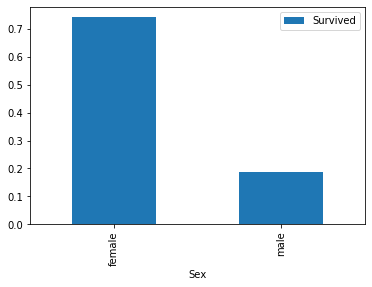

In [8]:
import matplotlib.pyplot as plt

sex_pivot = train.pivot_table(index='Sex', values='Survived')
sex_pivot.plot.bar()
plt.show()

We can immediately see that females survived in much higher proportions than males did.

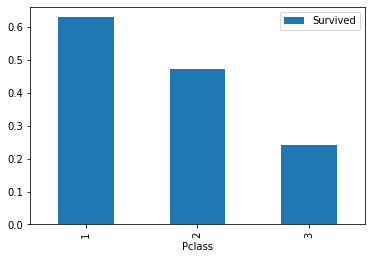

In [10]:
class_pivot = train.pivot_table(index='Pclass', values='Survived')
class_pivot.plot.bar()
plt.show()

As expected we can see a correlation

Let's take a look at the Age column using Series.describe()

In [12]:
print(train['Age'].describe())

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64


The Age column contains numbers ranging from 0.42 to 80.0 (If you look at Kaggle's data page, it informs us that Age is fractional if the passenger is less than one). The other thing to note here is that there are 714 values in this column, fewer than the 891 rows we discovered that the train data set had earlier in this mission which indicates we have some missing values.

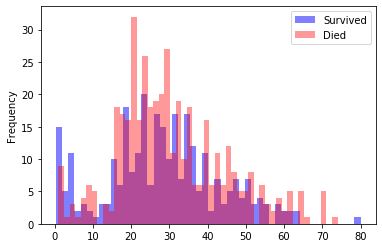

In [16]:
survived = train[train['Survived']== 1]
died = train[train['Survived']== 0]
survived['Age'].plot.hist(alpha=0.5, color = 'blue', bins=50)
died['Age'].plot.hist(alpha=.4, color = 'red', bins=50)
plt.legend(['Survived', 'Died'])
plt.show()

The relationship here is not simple, but we can see that in some age ranges more passengers survived - where the blue bars are higher than the red bars.

To make it more useful in our model:
we can separate this continuous feature into a categorical feature by dividing it into ranges.
But before we modify this column, we have to be aware of two things.
 - Firstly, any change we make to the train data, we also need to make to the test data, otherwise we will be unable to use our model to make predictions. 
 - Secondly, we need to handle the missing values we observed above.

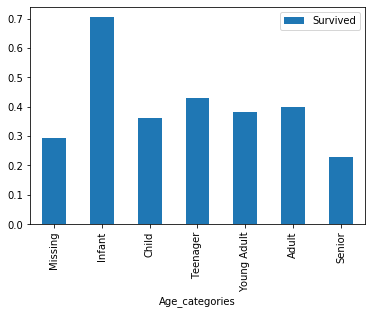

In [18]:
def process_age(df, cut_points, label_names):
    '''
    impute missing age with -0.5
    cut age column into segments
    
    Parameters:
        df: dataframe
        cut_points: bins for segments
        label_names: labels for resultant bins
        '''
    df['Age'] = df['Age'].fillna(-.05) #so the function can categorize as missing
    df['Age_categories'] = pd.cut(df['Age'], cut_points, labels = label_names)
    return df

cut_points = [-1, 0, 5, 12, 18, 35, 60, 100]
label_names = ['Missing','Infant', 'Child', 'Teenager', 'Young Adult', 'Adult', 'Senior']

train = process_age(train, cut_points, label_names)
test = process_age(test, cut_points, label_names)

pivot = train.pivot_table(index='Age_categories', values='Survived')
pivot.plot.bar()
plt.show()

So far we have identified three columns that may be useful for predicting survival:

 - Sex
 - Pclass
 - Age, or more specifically our newly created Age_categories

In [19]:
train['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

While the class of each passenger certainly has some sort of ordered relationship, the relationship between each class is not the same as the relationship between the numbers 1, 2, and 3. For instance, class 2 isn't "worth" double what class 1 is, and class 3 isn't "worth" triple what class 1 is.

In order to remove this relationship, we can create dummy columns for each unique value in Pclass, sex, and Age Categories
 - We'll use pandas.get_dummies() function for that


In [20]:
def create_dummies(df, column_name):
    dummies = pd.get_dummies(df[column_name], prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

train = create_dummies(train, 'Pclass')
test = create_dummies(test, 'Pclass')

train = create_dummies(train, 'Sex')
test = create_dummies(test, 'Sex')

train = create_dummies(train, 'Age_categories')
test = create_dummies(test, 'Age_categories')

In [21]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Pclass_3,Sex_female,Sex_male,Age_categories_Missing,Age_categories_Infant,Age_categories_Child,Age_categories_Teenager,Age_categories_Young Adult,Age_categories_Adult,Age_categories_Senior
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,1,0,1,0,0,0,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,0,1,0,0,0,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,1,1,0,0,0,0,0,1,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,0,1,0,0,0,0,0,1,0,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,1,0,1,0,0,0,0,1,0,0


Now that our data has been prepared, we are ready to train our first model. The first model we will use is called Logistic Regression

In [24]:
from sklearn.linear_model import LogisticRegression

#Create LogisticRegression object
lr = LogisticRegression()

#Fitting Model on our training dataset

columns = ['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Age_categories_Missing','Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior']

lr.fit(train[columns], train['Survived'])


C:\Users\AMAN3001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

### Testing Accuracy
We do have a test dataframe that we could use to make predictions. We could make predictions on that data set, but because it doesn't have the Survived column.
We can split our train dataframe into two:

 - One part to train our model on (often 80% of the observations)
 - One part to make predictions with and test our model (often 20% of the observations)
 
And to avoid confusion, from here on, we're going to call the actual **'test'** data **holdout** data

The scikit-learn library has a handy model_selection.train_test_split() function that we can use to split our data.

![train_test_split](kaggle_train_test_split.svg)

In [26]:
holdout = test # from now on we will refer to this dataframe as the holdout data

from sklearn.model_selection import train_test_split

columns = ['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Age_categories_Missing','Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior']

all_x = train[columns]
all_y = train['Survived']

train_x, test_x, train_y, test_y = train_test_split(all_x, all_y, test_size=0.20, random_state=0)

Now that we have our data split into train and test sets, we can fit our model again on our training set, and then use that model to make predictions on our test set.

In [27]:
from sklearn.metrics import accuracy_score
ir = LogisticRegression()
lr.fit(train_x, train_y)
predictions = lr.predict(test_x)
accuracy = accuracy_score(test_y, predictions)
print(accuracy)


0.8100558659217877


C:\Users\AMAN3001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Our model has an accuracy score of 81.0% when tested against our 20% test set. Given that this data set is quite small, there is a good chance that our model is overfitting, and will not perform as well on totally unseen data.

To give us a better understanding of the real performance of our model, we can use a technique called cross validation to train and test our model on different splits of our data, and then average the accuracy scores.
 - We'll use k-fold cross validation
 - We will use scikit-learn's model_selection.cross_val_score() function to automate the process.

In [29]:
from sklearn.model_selection import cross_val_score
import numpy as np
ir= LogisticRegression()
scores = cross_val_score(ir, all_x, all_y, cv=10)
accuracy = np.mean(scores)
print(scores)
print(accuracy)

[0.8        0.81111111 0.7752809  0.87640449 0.80898876 0.78651685
 0.76404494 0.76404494 0.83146067 0.80681818]
0.8024670865963002


C:\Users\AMAN3001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\AMAN3001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\AMAN3001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\AMAN3001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\AMAN3001\AppData\Local\Continuum\anaconda3\lib\site-package

**From the results of our k-fold validation, you can see that the accuracy number varies with each fold - ranging between 76.4% and 87.6% and our average accuracy score was 80.2%**

### Room for improvement
Improving the features:
 - Feature Engineering: Create new features from the existing data.
 - Feature Selection: Select the most relevant features to reduce noise and overfitting.
 
Improving the model:
 - Model Selection: Try a variety of models to improve performance.
 - Hyperparameter Optimization: Optimize the settings within each particular machine learning model.